In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style as style
style.use('seaborn-colorblind')

%matplotlib inline

/tmp/ipykernel_5799/3288383433.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


In [2]:
from file_manager import FileManager
fm = FileManager()

#### Exploring feature relationships
- The most important statitistic when attempting to win Fantasy contests is obviously fantasy points (fpts)
- The scoring rubric used for FanDuel scoring is:
    - 1 point (pts) = 1 fpts
    - 1 assist (ast) = 1.5 fpts
    - 1 rebound (trb) = 1.2 fpts
    - 1 steal or block (stl, blk) = 3 fpts
    - 1 turnover (tov) = -1 fpts
- Because of these scoring mechanisms, there will exist obvious correlations between each of this stats and fpts
- Additionally, one will want to analyze how other statistics might interact with fantasy points, such as minutes played (mp), usage (usg), and true shooting (ts)

- **Tools useful for exploring these relationships will be heatmaps, histograms, bar charts, and scatterplots**

In [3]:
def create_heatmap(**kwargs):

    features: list[str,...] = ['fpts', 'mp', 'pts', 'ast', 'trb', 'stl', 'blk', 'usg', 'ts']
    if kwargs.get('features') is not None:
        features: list[str,...] = sum([features, kwargs['features']], [])
    
    if kwargs.get('remove') is not None:
        remove = kwargs['remove']
        if isinstance(remove, str): remove = (remove,)
        
        features: list[str,...] = [feat for feat in features if feat not in remove]
    
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else ( int(kwargs['starter']), )
        
    if kwargs.get('product') is not None:
        features: list[str,...] = sum([features, [feat for feat in kwargs['product'] if feat not in features]], [])
    
    df: pd.DataFrame = (fm.load_clean_data()
                        .pipe(lambda df_: df_.loc[df_['starter'].isin(starter_)])
                        [features]
                       )
        
    if kwargs.get('product') is not None:
#         features: list[str,...] = sum([features, [feat for feat in kwargs['product'] if feat not in features]], [])
        for cols in itertools.combinations(kwargs['product'], 2):
            df['*'.join(cols)] = df[cols[0]]*df[cols[1]]
    
    print(f'Sample size: {df.shape[0]:,}\n')
    
    corr: pd.DataFrame = df.corr()
        
    # Better size
    fig, ax = plt.subplots(figsize=kwargs.get('figsize', (15,10)))
    mask: np.ndarray = np.triu(np.ones_like(corr, dtype=bool))
    
    # Preferred kwargs for heatmap that are not defaults
    sns_kwargs: dict[str,str|float] = {
        'cmap': kwargs.get('cmap', 'jet_r'),
        'vmin': kwargs.get('vmin', 0.4),
        'vmax': kwargs.get('vmax', 1.0)
        
    }
    
    return sns.heatmap(
        corr, 
        mask=mask,
        **sns_kwargs
    ) 

Sample size: 20,876



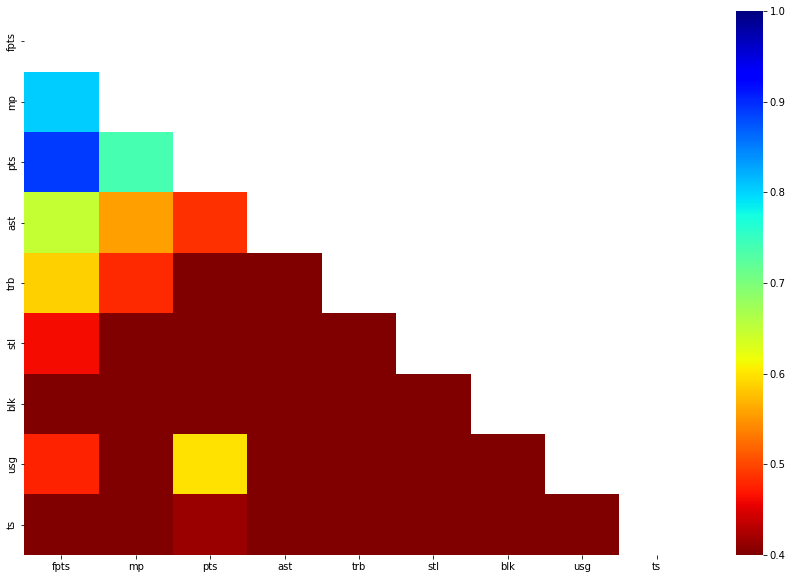

In [4]:
create_heatmap();

- **As one can see, *pts* has the highest correlaion with fpts, which makes sense as NBA players with high fpts are more likely to have gotten relatively high points as compared to assists or rebounds, despite these two stats having higher multipliers. Therefore one can possibly conclude that scoring players might be better picks than rebound/assist players**

- ***mp* ranks next strongest, which intuitively makes sense since more time on the floor translates to more opportunity to gain fpts**

- **Similarly, despite stl and blk having the same multipliers, *stl* possess a higher correlation with fpts. One possiblity for this could be that steals translate into fast-breaks which present opportunities for assists or points, whereas blocks tend to leave opposing teams with possessions and deny points to the an opposing player, which cannot be as easily seen in the data.**

- ***usg* appears to be another useful statistic for predicting fpts which is evident in both its correlation with fpts as well as its correlation with *pts*, which, as mentioned above, illustrates the strongest correlation with fpts. *ts* lacks a strong correlation with fpts but appears to have a slight correlation with *pts*, not great but enough to potentially investigate**

Sample size: 20,876



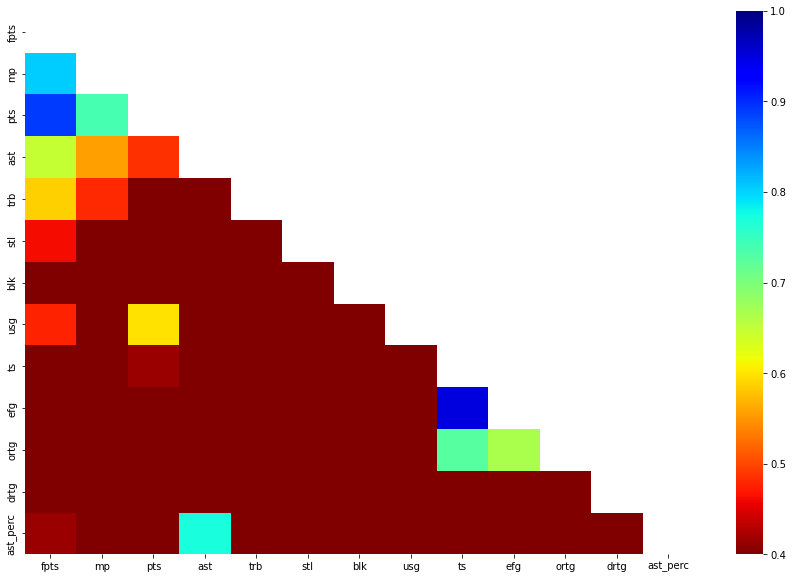

In [5]:
# create_heatmap() can take in additional parameters, including features to explore beyond the ones already mentioned
# For example, can analyze if effective field goal percentage has any relationships
create_heatmap(
    features=['efg', 'ortg', 'drtg', 'ast_perc']
);

-*Not much realtionship with* fpts *but a very strong correlation with* ts

Sample size: 8,710



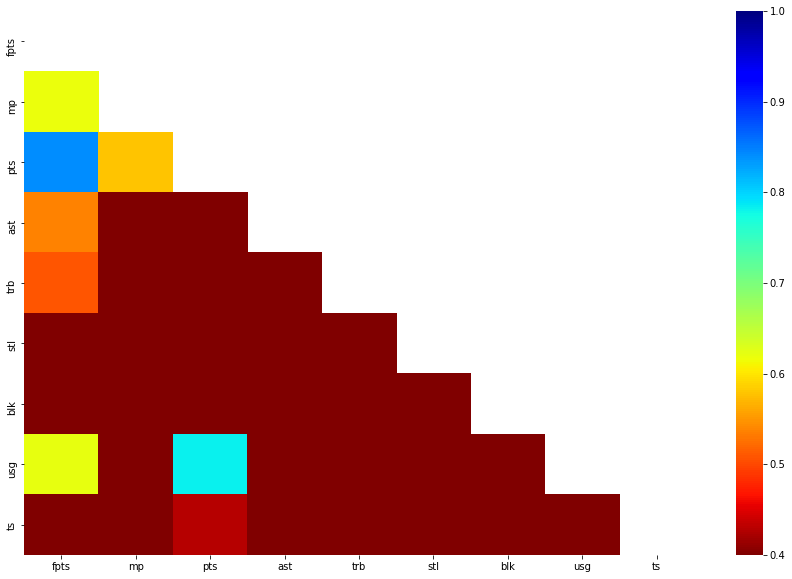

In [6]:
# Another useful parameter is to analyze only starters, which shrinks the sample size and the variance, but increases median minutes played
create_heatmap(
    starter=True
);

Sample size: 9,652



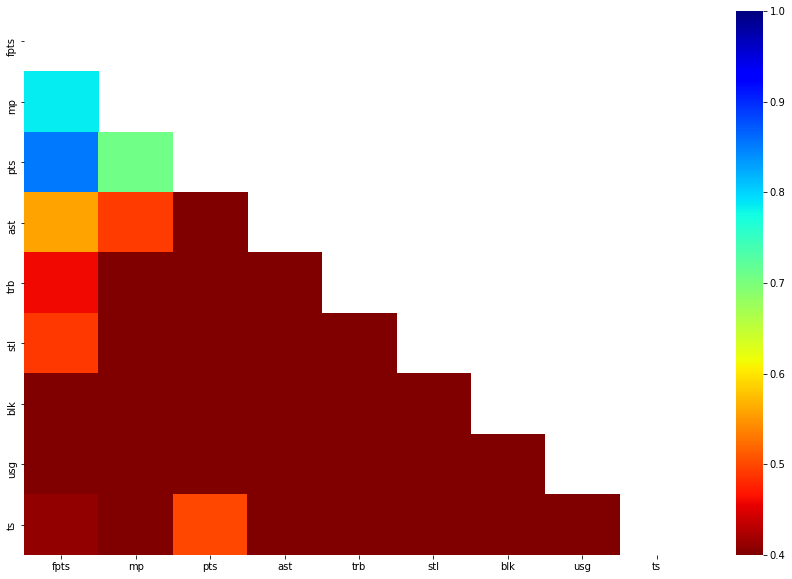

In [7]:
create_heatmap(
    starter=False
);

- *While it is not good practice to try and delve too deep into reasons why changes may occur without further investigating, one can still see that points and minutes played maintain a strong relationship while assists, rebounds, usg becomes weaker for players coming off the bench. Therefore if one is selecting nonstarters, one would see the best return on fpts if getting the primary scorer for bench players and/or nonstarters playing significant minutes, two factors most likely to be heavily intersected*

- *Another thing to notice, however, is the relationship between usg and fpts becomes much stronger when dealing with starters vs with dealing with everyone / nonstarters*

Sample size: 18,362



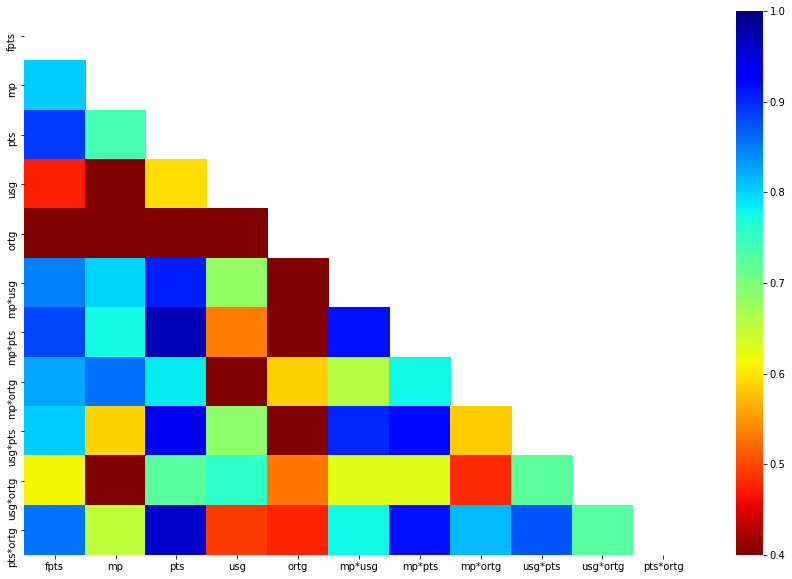

In [18]:
# Another useful parameter in my heatmap function is illustrating the correlations that occur between the products of two columns and the rest of the stats
# This is extremely useful in demonstrating / compounding relationships between features, and is very important in helping to improve modeling later on
# NOTE: I wrote my own simple version of performing this task in create_heatmap(), but will be using the libraries for feature engineering in scikitlearn for modeling to optimize performance

# An example of this will be illustrating the relationships between the products of usg, pts, mp; I will remove the nonimportant features for this to improve inference
create_heatmap(
    remove=['ts', 'stl', 'blk', 'trb', 'ast'],
    product=['mp', 'usg', 'pts', 'ortg']
);

- **One can easily see now that usage becomes much better for predicting fpts when taking its product with minutes played rather than just usage alone**

#### Important Note Regarding Data

- While it seems that there are many strong patterns and relationships evident in this dataset, it is extemely import to remember that these features are not wholly independent from one another. 
    - Rather they tell an important story about what player profiles in general are good for competing in fantasy: lots of minutes, and high usage/good scorers (usage is derived from how many shots a player takes in that game, so these two features are intertwined).
    - When choosing players who are good at defense, players who get steals are better than players who get blocks because of the opportunities stealing the ball provides for that player.

- When trying to construct a predictive model for fantasy points, it will be difficult to incorporate most of this data for two reasons:
    1. The high levels of dependence among features
    2. The lack of information prior to the game regarding most of these features. One can use the mean/median of players for these features for determining if in general they are good fantasy players, but one cannot plug these stats in as inputs into a model as it will cause issues.
    3. Information such as the O/U and spread (given by Las Vegas prior to each game and based on historical team outcomes, and related to `total_pts` and `pts_diff`) are examples of information that can be plugged into a predictive model, as well as other data regarding teams/matchups such as pace and defensive rtg (need to get from somewhere else) 

- ***This dataset as it exists now is much more useful for inference than prediction***

- When building a predictive model, will most likely only be using minutes played and usage as inputs (medians) as these remain relatively constant for players compared to most other stats: NBA offenses tend to revolve around the star players getting more of the shots/pts whereas it is much easier for volatility to occur in stats such as rebounds, steals, and blocks